### **Git Clone**

In [4]:
# !cd git_repo & git clone https://github.com/Farama-Foundation/ViZDoom.git

In [1]:
# Import vizdoom for game environment
from vizdoom import *
import numpy as np
import time
import random



In [36]:
# Setup the game
game = DoomGame()
game.load_config('git_repo/ViZDoom/scenarios/deadly_corridor_s1.cfg')
game.init()

In [37]:
# Three action choices
actions = np.identity(7, dtype=np.uint8)
actions

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [38]:
random.choice(actions)

array([0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [39]:
# This should be match observation space below
game.get_state().screen_buffer.shape

(3, 240, 320)

In [84]:
game.get_state().game_variables

array([100.,   0.,   0.,  -1.])

In [85]:
# Take random actions without tranning RL model
game.make_action(random.choice(actions))

0.0

In [ ]:
episodes = 1
for episode in range(episodes):
    game.new_episode() # Start a new episode
    while not game.is_episode_finished():
        # Get the game state
        state = game.get_state()
        # Get the game image in RGB format
        img = state.screen_buffer
        # Get the game variables (e.g. health, ammo, score)
        info = state.game_variables
        # Do something and skip 4 frames
        reward = game.make_action(random.choice(actions), 4)
        # Print the reward
        # print("Reward: ", reward)
        time.sleep(0.02)
    print("Result:", game.get_total_reward())
    time.sleep(2)


In [ ]:
# Result: 269.34083557128906
# Result: 106.83609008789062
# Result: -104.51791381835938
# Result: -107.55477905273438
# Result: -99.47566223144531

In [86]:
game.close()

### **Converting it to a Gym Envirnoment**
- Three additional parameter added in this environment:
    - DAMAGE_TAKEN
    - HITCOUNT
    - SELECTED_WEAPON_AMMO

In [9]:
# !pip install gym
# !pip install opencv-python

In [2]:
from gymnasium import Env  # Use gymnasium instead of gym
from gymnasium.spaces import Box, Discrete
from vizdoom import DoomGame
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [96]:
# its works like random function in gym environment
Discrete(7).sample()

3

In [105]:
actions[Discrete(7).sample()]

array([0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [106]:
# This is provide like actual image
Box(low=0, high=10, shape=(10,10), dtype=np.uint8).sample()

array([[ 8, 10,  8,  7,  9,  5,  8,  7,  3, 10],
       [ 1, 10,  7,  6,  5,  2,  2,  8,  2,  7],
       [10,  9, 10,  0,  5,  4,  9,  3,  6,  6],
       [ 8,  8,  9,  6,  7, 10,  1,  8,  1,  7],
       [ 8,  5,  3,  6,  7,  7,  9, 10,  0,  3],
       [ 0,  1,  8,  1, 10,  8,  4,  1,  5,  6],
       [ 7,  1,  9,  7,  6,  2,  4,  9, 10,  7],
       [ 1,  2,  9,  9,  8,  7,  4,  8,  0,  2],
       [ 4,  6,  4,  0,  2,  3, 10,  9,  7,  3],
       [ 9, 10,  6,  7,  8,  2,  6,  1,  4,  6]], dtype=uint8)

In [32]:
# Create the Gaming Environment

class VizDoomEnv(Env):  # Correct inheritance
    def __init__(self, config = 'git_repo/ViZDoom/scenarios/deadly_corridor_s3.cfg'):
        super().__init__()

        # Create the gaming environment
        self.game = DoomGame()

        # Load configuration and initialize the game
        self.game.load_config(config)
        self.game.init()

        # Define observation and action spaces
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)

        # Game Variable:  HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        # Game Variable: 100.0 0.0 0.0 -1.0
        self.damage_taken = 0
        self.hit_count = 0
        self.selected_weapon_ammo = 60 

    def step(self, action):
        # Specify the action and time step
        actions = np.identity(7, dtype=np.uint8)
        movement_reward = self.game.make_action(actions[action], 4)

        reward = 0
        
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            # Reshaping rewards
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hit_count, selected_weapon_ammo = game_variables
            
            # Calculate reward deltas
            delta_damaged_taken = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken

            delta_hit_count = hit_count - self.hit_count
            self.hit_count = hit_count

            delta_selected_weapon_ammo = selected_weapon_ammo - self.selected_weapon_ammo
            self.selected_weapon_ammo = selected_weapon_ammo

            reward = movement_reward + delta_damaged_taken*10 + delta_hit_count*200 + delta_selected_weapon_ammo*5
            info = {
                "selected_weapon_ammo": selected_weapon_ammo,
                "damage_taken": damage_taken,
                "hit_count": hit_count,
                "health": health
            }



        else:
            state = np.zeros(self.observation_space.shape, dtype=np.uint8)
            info = {}

        terminated = self.game.is_episode_finished()
        truncated = False  # In this example, we are not using a time limit

        return state, reward, terminated, truncated, info


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.game.new_episode()
        state = self.game.get_state()

        if state:
            return self.grayscale(state.screen_buffer), {}
        else:
            # Return a blank observation if no state is available
            return np.zeros((100, 160, 1), dtype=np.uint8), {}

    def grayscale(self, observation):
        # Convert the observation to grayscale
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_RGB2GRAY)

        # Crop the image to remove borders (e.g., HUD or extra information)
        # cropped = gray[20:200, :]  # Adjust cropping as needed (y_start:y_end, x_start:x_end)

        # Resize the cropped image to the desired dimensions (e.g., 160x100)
        resized = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)

        # Add a channel dimension (required by some frameworks)
        state = np.reshape(resized, (100, 160, 1))

        return state

    def render(self, mode="human"):
        pass

    def close(self):
        self.game.close()



In [33]:
class VizDoomEnv2(Env):
    def __init__(self, config='git_repo/ViZDoom/scenarios/deadly_corridor_s5.cfg'):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config(config)
        self.game.init()

        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)

        self.damage_taken = 0
        self.hit_count = 0
        self.selected_weapon_ammo = 60

    def step(self, action):
        actions = np.identity(7, dtype=np.uint8)
        movement_reward = self.game.make_action(actions[action], 4)

        if self.game.get_state():
            state = self.grayscale(self.game.get_state().screen_buffer)
            game_variables = self.game.get_state().game_variables

            # Handle cases where game_variables is None or has an unexpected shape
            if game_variables is None or len(game_variables) < 4:
                health, damage_taken, hit_count, selected_weapon_ammo = 100, 0, 0, 60  # Default values
            else:
                health, damage_taken, hit_count, selected_weapon_ammo = game_variables

            # Calculate deltas for rewards
            delta_damage_taken = self.damage_taken - damage_taken
            self.damage_taken = damage_taken

            delta_hit_count = hit_count - self.hit_count
            self.hit_count = hit_count

            delta_selected_weapon_ammo = selected_weapon_ammo - self.selected_weapon_ammo
            self.selected_weapon_ammo = selected_weapon_ammo

            reward = (
                movement_reward +
                delta_damage_taken * -1 +
                delta_hit_count * 10 +
                delta_selected_weapon_ammo * -0.1
            )
            info = {
                "selected_weapon_ammo": selected_weapon_ammo,
                "damage_taken": damage_taken,
                "hit_count": hit_count,
                "health": health,
            }
        else:
            state = np.zeros(self.observation_space.shape, dtype=np.uint8)
            reward, info = 0, {}

        terminated = self.game.is_episode_finished()
        truncated = False

        return state, reward, terminated, truncated, info


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.game.new_episode()

        self.damage_taken = 0
        self.hit_count = 0
        self.selected_weapon_ammo = 60

        state = self.game.get_state()
        if state:
            return self.grayscale(state.screen_buffer), {}
        else:
            return np.zeros(self.observation_space.shape, dtype=np.uint8), {}

    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_LINEAR)
        return np.reshape(resized, (100, 160, 1))

    def close(self):
        self.game.close()


### **3. View Game State**

In [25]:
env1 = VizDoomEnv()
env2 = VizDoomEnv2()

In [5]:
state, _ = env1.reset()  # Unpack the tuple

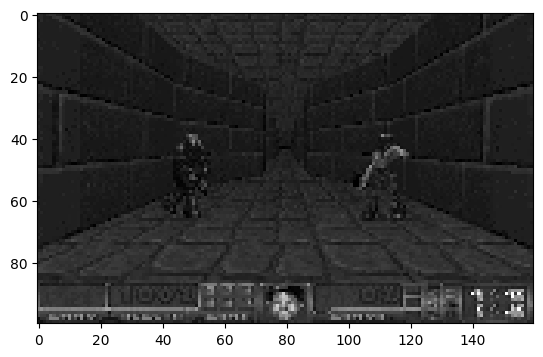

In [6]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))
plt.show()

In [125]:
print(state.shape)

(100, 160, 1)


In [ ]:
env.step(2)

##### **_Check Environment with Stable Baseline_**

In [7]:
# Environment checker from stable-baselines3
from stable_baselines3.common.env_checker import check_env

check_env(env)

In [377]:
# This kind of input expected for the opencv to convert into gray scale image
np.moveaxis(state, 0, -1).shape

(160, 1, 100)

In [92]:
# We want the same of the observation space to mathc the game frame exactly.
env.observation_space.sample().shape

(3, 240, 320)

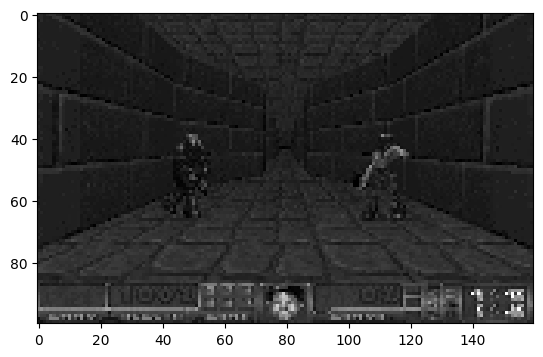

In [8]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))
plt.show()

### **4. Setup Callback**

In [10]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO

In [11]:
## Saving the model
class TranningAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TranningAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model{self.n_calls}')
            self.model.save(model_path)

        return True

In [31]:
# Directories for checkpoints and logs
CHECKPOINT_DIR = 'training/deadly_corridor/s1'
LOG_DIR = 'logs/deadly_corridor/s1'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
callback = TranningAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

### **5. Train Model using reward shaping and curriculum learning**

In [66]:
# Trained model on each of the level gradually and fine tunning
# git_repo/ViZDoom/scenarios/deadly_corridor_s1.cfg
# git_repo/ViZDoom/scenarios/deadly_corridor_s2.cfg
# git_repo/ViZDoom/scenarios/deadly_corridor_s3.cfg
# git_repo/ViZDoom/scenarios/deadly_corridor_s4.cfg
# git_repo/ViZDoom/scenarios/deadly_corridor_s5.cfg

In [ ]:

# Train on level `s1`
env = VizDoomEnv(config='git_repo/ViZDoom/scenarios/deadly_corridor_s1.cfg')
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.00001, n_steps=8192, clip_range=0.1, gamma=0.95, gae_lambda=0.9)
model.learn(total_timesteps=400000, callback=callback)

In [8]:
# Load the model trained on `s1`
CHECKPOINT_DIR = 'training/deadly_corridor/s2'
LOG_DIR = 'logs/deadly_corridor/s2'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

env = VizDoomEnv(config='git_repo/ViZDoom/scenarios/deadly_corridor_s2.cfg')

model = PPO.load('training/deadly_corridor/s1/best_model240000.zip')
model.set_env(env)



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train on level `s2`
model.learn(total_timesteps=400000, callback=callback)

In [36]:
# Load the model trained on `s2`
CHECKPOINT_DIR = 'training/deadly_corridor/s3'
LOG_DIR = 'logs/deadly_corridor/s3'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# env = VizDoomEnv(config='git_repo/ViZDoom/scenarios/deadly_corridor_s3.cfg')

# model = PPO.load('training/deadly_corridor/s2/best_model300000.zip')
# model.set_env(env)




model = PPO(
    'CnnPolicy',
    env,
    verbose=1,
    tensorboard_log=LOG_DIR,
    learning_rate=3e-5,         # Increased learning rate
    n_steps=4096,              # Reduced steps per update
    batch_size=64,             # Smaller batch size
    clip_range=0.2,            # Wider clip range
    gamma=0.99,                # Higher discount factor
    gae_lambda=0.95,           # Improved advantage estimation
    ent_coef=0.01,             # Encourage exploration
    vf_coef=0.5,               # Scale value function loss
)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [37]:
# Train on level `s3`
model.learn(total_timesteps=400000, callback=callback)

Logging to logs/deadly_corridor/s3\PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.2     |
|    ep_rew_mean     | 57.7     |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 142      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 78.8        |
|    ep_rew_mean          | 52.5        |
| time/                   |             |
|    fps                  | 29          |
|    iterations           | 2           |
|    time_elapsed         | 273         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009473899 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -1.

In [ ]:
# Load the model trained on `s3`
CHECKPOINT_DIR = 'training/deadly_corridor/s4'
LOG_DIR = 'logs/deadly_corridor/s4'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

env = VizDoomEnv(config='git_repo/ViZDoom/scenarios/deadly_corridor_s4.cfg')

model = PPO.load('training/deadly_corridor/s3/final_model')
model.set_env(env)



In [ ]:
# Train on level `s4`
model.learn(total_timesteps=400000, callback=callback)

In [59]:
# Load the model trained on `s2`
CHECKPOINT_DIR = 'training/deadly_corridor/s5'
LOG_DIR = 'logs/deadly_corridor/s5'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [60]:
callback = TranningAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [61]:
env = VizDoomEnv(config='git_repo/ViZDoom/scenarios/deadly_corridor_s5.cfg')
# env2 = VizDoomEnv2(config='git_repo/ViZDoom/scenarios/deadly_corridor_s5.cfg')

In [ ]:
# # Load the best model
# model = PPO.load('training/deadly_corridor/s1/best_model460000.zip')
# model.set_env(env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [62]:
# This is a environment 1 scripts


model = PPO(
    'CnnPolicy',
    env,
    verbose=1,
    tensorboard_log=LOG_DIR,
    learning_rate=1e-5,         # Increased learning rate
    n_steps=8192,              # Reduced steps per update
    batch_size=256,             # Smaller batch size
    clip_range=0.2,            # Wider clip range
    gamma=0.99,                # Higher discount factor
    gae_lambda=0.95,           # Improved advantage estimation
    ent_coef=0.01,             # Encourage exploration
    vf_coef=0.5,               # Scale value function loss
    max_grad_norm=0.5
)


# # This is a environment 2 scripts
# model = PPO(
#     'CnnPolicy',
#     env2,
#     verbose=1,
#     tensorboard_log=LOG_DIR,
#     learning_rate=1e-5,         # Lower learning rate
#     n_steps=8192,              # More steps for long episodes
#     batch_size=128,            # Larger batch size for stability
#     clip_range=0.2,            # Allow flexible policy updates
#     gamma=0.995,               # Longer-term rewards
#     gae_lambda=0.95,           # Smooth advantage estimation
#     ent_coef=0.03,             # Encourage exploration
#     vf_coef=0.7,               # Better value function scaling
#     max_grad_norm=0.5          # Gradient clipping for stability
# )



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train on level `s5`
model.learn(total_timesteps=550000, callback=callback)

In [ ]:
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Evaluation: Mean reward = {mean_reward:.2f}, Std = {std_reward:.2f}")


In [140]:
game.close()

### **6. Test the model**

In [67]:
from stable_baselines3.common.evaluation import evaluate_policy

In [68]:
model = PPO.load('training/deadly_corridor/s1/best_model460000.zip')

In [86]:
# Create the environment
env = VizDoomEnv(config='git_repo/ViZDoom/scenarios/deadly_corridor_s5_test.cfg')

In [25]:
# Evualuate the mean reward over 10 episodes
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: 242.73 +/- 297.61


In [73]:
env.close()

In [87]:
for episode in range(20):
    obs, _ = env.reset()
    done = False
    total_reward_episode = 0
    while not done:
        actopm, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(actopm)
        total_reward_episode += reward
        time.sleep(0.02)

    print(f"Episode {episode} finished with total reward: {total_reward_episode}")
    time.sleep(2)
env.close()

Episode 0 finished with total reward: 32.713592529296875
Episode 1 finished with total reward: 400.68902587890625
Episode 2 finished with total reward: 274.26300048828125
Episode 3 finished with total reward: 1080.8023834228516
Episode 4 finished with total reward: -454.21173095703125
Episode 5 finished with total reward: 415.0170135498047
Episode 6 finished with total reward: 324.3609161376953
Episode 7 finished with total reward: 300.2388610839844
Episode 8 finished with total reward: -34.19349670410156
Episode 9 finished with total reward: 259.38475036621094
Episode 10 finished with total reward: 1344.8946533203125
Episode 11 finished with total reward: 199.53475952148438
Episode 12 finished with total reward: 252.35484313964844
Episode 13 finished with total reward: 383.15956115722656
Episode 14 finished with total reward: 871.8843536376953
Episode 15 finished with total reward: 287.11061096191406
Episode 16 finished with total reward: 208.39212036132812
Episode 17 finished with to

: 